Import necessari:

In [37]:
import os

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from collections import Counter, defaultdict

from scipy.ndimage import convolve
from scipy.stats import skew

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from skimage.feature import hog
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_recall_fscore_support,
    pairwise_distances,
    confusion_matrix
)
from sklearn.manifold import MDS, TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.tree import DecisionTreeClassifier

from PIL import Image

from torchvision.io import read_image
from torchvision.transforms import functional as F

try:
    import umap
except ImportError:
    print("[WARNING] UMAP non disponibile\n")

Set Up

In [2]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])

feat_matrix_part1, lbls_part1, flname_part1 = load_features("hog_features_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features("hog_features_part2.npz")

In [3]:
# Ritaglia l'area informativa (cervello) da un'immagine
def crop_to_brain(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        return img[y:y+h, x:x+w]
    return img

## Task 1
Histograms of oriented gradients, HOG: Mappa l'immagine in scala di grigi, ridimensiona l'immagine a 300 x 10, partiziona l'immagine in una griglia 10x10, calcola l'istogramma del gradiente con  magnitude-weighted a 9 bin (con segno) (ogni bin corrispondente a 40 gradi) per ogni cella della griglia e combina questi istogrammi in un descrittore di feature di dimensione 10x10x9 = 900.    
<br>Puoi usare {-1, 0, 1} e {-1, 0, 1}^T maschere per ottenere dI/dx e dI/dy per ogni posizione di pixel nella cella della griglia.

## Task 2
Implementa un programma che **estrae e memorizza i descrittori di feature** per tutte le immagini nel set di dati.

In [4]:
# Calcola i gradienti HOG e restituisce tutti i dati intermedi per analisi e feature extraction
def compute_hog_gradients(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    img = crop_to_brain(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (300, 10))

    # Calcola i gradienti attraverso filtro Sobel
    mask_x = np.array([[-1, 0, 1]])
    mask_y = np.array([[-1], [0], [1]])

    gradient_x = convolve(resized.astype(np.float32),
                          mask_x, mode='constant', cval=0)
    gradient_y = convolve(resized.astype(np.float32),
                          mask_y, mode='constant', cval=0)

    # Calcola magnitude e orientazione
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    angle = np.arctan2(gradient_y, gradient_x)
    angle_degree = (np.degrees(angle) + 360) % 360

    # Restituisce un dizionario con tutti i dati
    return {
        'resized_image': resized,
        'gradient_x': gradient_x,
        'gradient_y': gradient_y,
        'magnitude': magnitude,
        'angle_degree': angle_degree,
        'original_shape': resized.shape
    }

In [5]:
# Estrae le feature HOG dai gradienti pre-calcolati
def extract_hog_features_from_gradients(gradient_data):
    if gradient_data is None:
        return None

    magnitude = gradient_data['magnitude']
    angle_degree = gradient_data['angle_degree']

    # Partiziona in griglia 10x10
    cell_height = magnitude.shape[0] // 10  # 30
    cell_width = magnitude.shape[1] // 10   # 1

    # Inizializza il descrittore HOG
    hog_features = np.zeros((10, 10, 9))

    # Per ogni cella della griglia
    for i in range(10):
        for j in range(10):
            # Estrai la cella
            start_row = i * cell_height
            end_row = start_row + cell_height
            start_col = j * cell_width
            end_col = start_col + cell_width

            cell_magnitude = magnitude[start_row:end_row, start_col:end_col]
            cell_orientation = angle_degree[start_row:end_row,
                                            start_col:end_col]

            # Calcola l'istogramma a 9 bin
            histogram = np.zeros(9)

            for y in range(cell_magnitude.shape[0]):
                for x in range(cell_magnitude.shape[1]):
                    angle = cell_orientation[y, x]
                    mag = cell_magnitude[y, x]

                    # Determina il bin (0-8 per 9 bin)
                    bin_idx = int(angle // 40) % 9

                    # Aggiungi magnitude-weighted
                    histogram[bin_idx] += mag

            # Salva l'istogramma nella posizione corretta
            hog_features[i, j, :] = histogram

    # Flatten per ottenere il descrittore finale
    hog_descriptor = hog_features.flatten()

    return hog_descriptor, hog_features

In [6]:
# Wrapper per tra calolo gradiente ed estrazione features
def extract_hog_features(img_path):
    gradient_data = compute_hog_gradients(img_path)
    if gradient_data is None:
        return None

    hog_descriptor, _ = extract_hog_features_from_gradients(gradient_data)
    return hog_descriptor

In [7]:
# Analizza + Plot della distribuzione dei gradienti HOG
def analyze_hog_gradient_distribution(img_path):
    gradient_data = compute_hog_gradients(img_path)
    if gradient_data is None:
        return None

    magnitude = gradient_data['magnitude']
    angle_degree = gradient_data['angle_degree']
    gradient_x = gradient_data['gradient_x']
    gradient_y = gradient_data['gradient_y']
    resized_image = gradient_data['resized_image']

    # Crea visualizzazioni
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Immagine originale ridimensionata
    axes[0].imshow(resized_image, cmap='gray', aspect='auto')
    axes[0].set_title('Immagine Ridimensionata (300x10)')
    axes[0].axis('off')

    # 2. Magnitude dei gradienti
    axes[1].imshow(magnitude, cmap='hot', aspect='auto')
    axes[1].set_title('Magnitude dei Gradienti')
    axes[1].axis('off')

    # 3. Orientazioni dei gradienti
    axes[2].imshow(angle_degree, cmap='hsv', aspect='auto')
    axes[2].set_title('Orientazioni (0-360°)')
    axes[2].axis('off')
    
    fig, axes_dstribution = plt.subplots(1, 2, figsize=(15,4))
    # 4. Distribuzione delle magnitude
    axes_dstribution[0].hist(magnitude.flatten(), bins=50, alpha=0.7, density=True)
    axes_dstribution[0].set_title('Distribuzione Magnitude')
    axes_dstribution[0].set_xlabel('Magnitude')
    axes_dstribution[0].set_ylabel('Densità')
    axes_dstribution[0].grid(True, alpha=0.3)

    # 5. Distribuzione delle orientazioni
    axes_dstribution[1].hist(angle_degree.flatten(), bins=36, alpha=0.7, density=True)
    axes_dstribution[1].set_title('Distribuzione Orientazioni')
    axes_dstribution[1].set_xlabel('Orientazione (gradi)')
    axes_dstribution[1].set_ylabel('Densità')
    axes_dstribution[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#  Plot distribuzione delle feature HOG
def plot_hog_features_distribution(img_path):
    gradient_data = compute_hog_gradients(img_path)
    if gradient_data is None:
        return None

    hog_descriptor, hog_features = extract_hog_features_from_gradients(
        gradient_data)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Distribuzione delle feature HOG
    axes[0].hist(hog_descriptor, bins=50, alpha=0.7, density=True)
    axes[0].set_title('Distribuzione Feature HOG')
    axes[0].set_xlabel('Valore Feature')
    axes[0].set_ylabel('Densità')
    axes[0].grid(True, alpha=0.3)

    # 2. Heatmap delle feature per cella (media sui 9 bin)
    hog_mean = np.mean(hog_features, axis=2)
    sns.heatmap(hog_mean, cmap='viridis', ax=axes[1])
    axes[1].set_title('Feature HOG Medie per Cella')
    axes[1].set_xlabel('Colonna')
    axes[1].set_ylabel('Riga')

    # 3. Distribuzione per bin di orientazione
    bin_sums = np.sum(hog_features, axis=(0, 1))
    bin_labels = [f'Bin {i}\n({i*40}°-{(i+1)*40}°)' for i in range(9)]
    axes[2].bar(range(9), bin_sums, alpha=0.7)
    axes[2].set_title('Distribuzione per Bin di Orientazione')
    axes[2].set_xlabel('Bin di Orientazione')
    axes[2].set_ylabel('Somma delle Feature')
    axes[2].set_xticks(range(9))
    axes[2].set_xticklabels([f'{i*40}°' for i in range(9)], rotation=45)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [8]:
#Generare heatmap basandosi su features estratte da hog
def show_mean_heatmap(img_path):
    # Estrai le feature come già fai nella tua pipeline
    feats = extract_hog_features(img_path)
    # (righe, colonne, canali, momenti)
    m = np.reshape(feats, (10, 10, 3, 3))
    # 1° canale, 1° momento (= media)
    mean_gray = m[:, :, 0, 0]

    plt.figure(figsize=(6, 3))
    plt.imshow(mean_gray, cmap='hot', interpolation='nearest')
    plt.title('Mean intensity per cell')
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [9]:
# Estrae le feature da immagini organizzate in sottocartelle e le salva in un file .npz
def process_and_save_features(base_folder, subfolders, output_file):

    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_hog_features(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
    
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    print(f"[SALVATO] Features salvate in {output_file}")

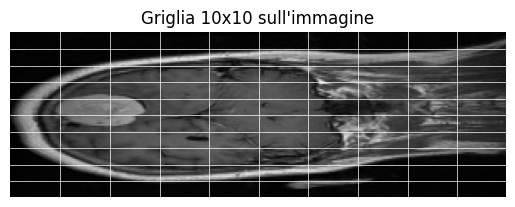

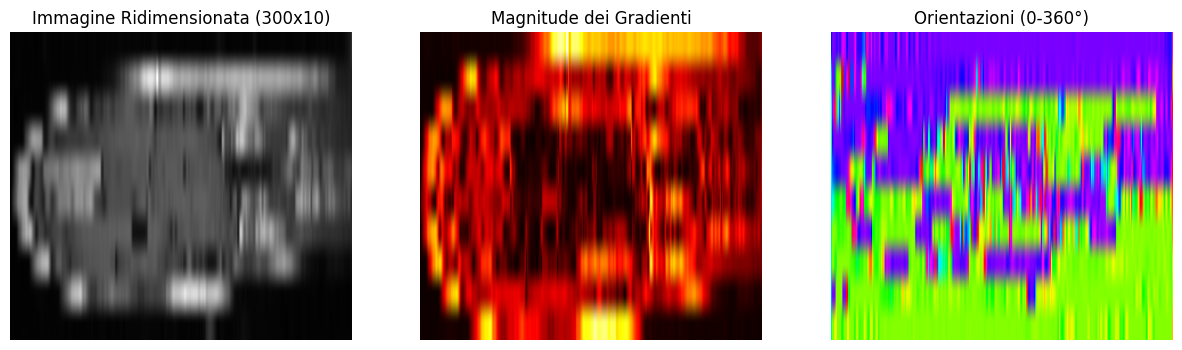

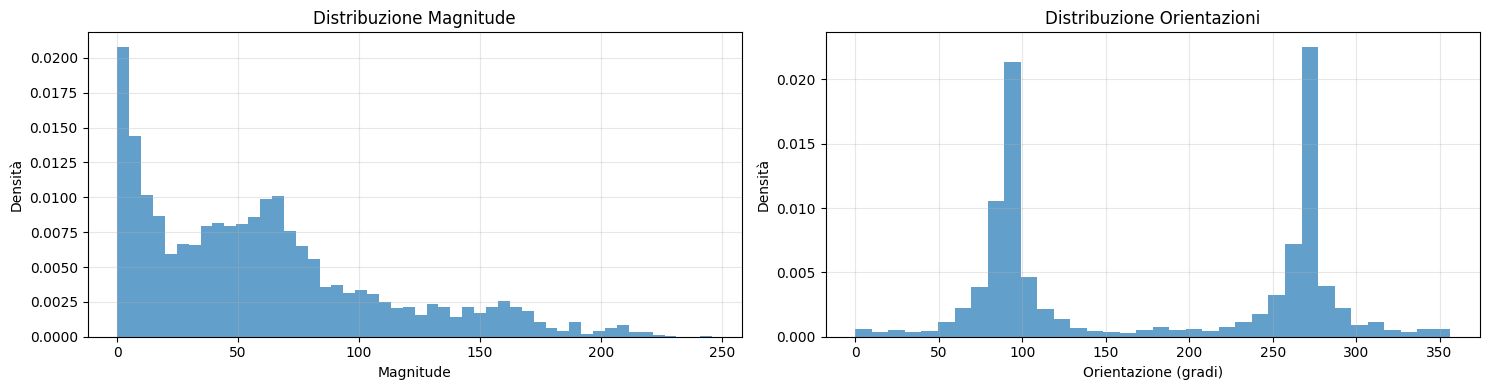

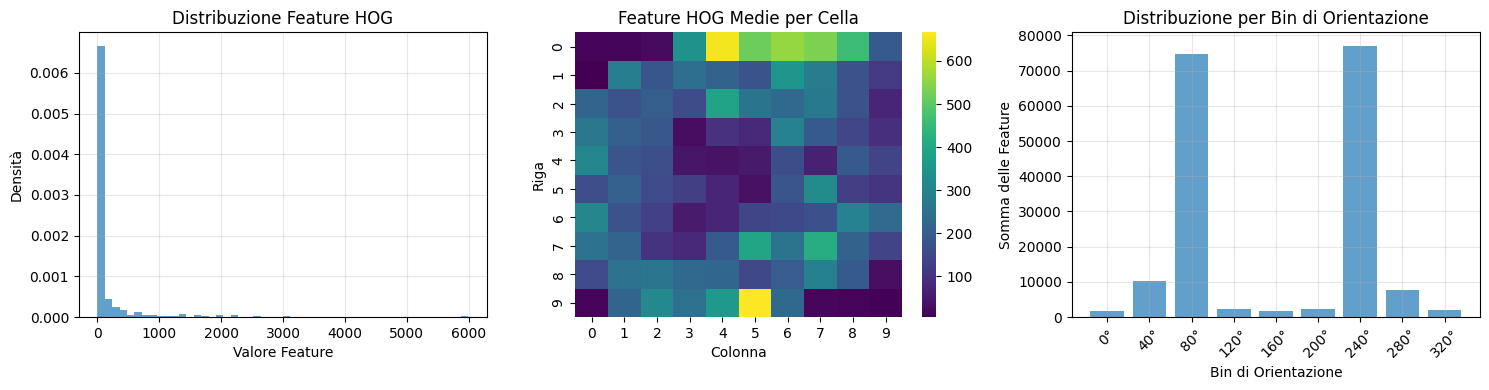

In [10]:
if __name__ == "__main__":
    # Inserisci il path a una immagine del dataset
    img_path = "Part1/brain_menin/brain_menin_0050.jpg"

    # Visualizza la griglia
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_to_brain(img)
    img = cv2.resize(img, (300, 100))

    fig, ax = plt.subplots()
    ax.imshow(img)
    for i in range(1, 10):
        ax.axhline(i * 10, color='white', linewidth=0.5)
        ax.axvline(i * 30, color='white', linewidth=0.5)
    ax.set_title("Griglia 10x10 sull'immagine")
    plt.axis('off')
    plt.show()

    analyze_hog_gradient_distribution(img_path)
    plot_hog_features_distribution(img_path)

In [11]:
# Parametri
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "hog_features_part1.npz")
process_and_save_features("Part2", subfolders, "hog_features_part2.npz")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in hog_features_part1.npz
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in hog_features_part2.npz


In [12]:
#Analizza e visualizza la distribuzione dei gradienti di HOG
def analyze_hog_gradient_distribution(img_path):
    # Carica e preprocessa l'immagine
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))

    # Metodo 1: Usando skimage HOG con visualizzazione
    features, hog_image = hog(resized,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              block_norm='L2-Hys')

    # Metodo 2: Calcolo esplicito dei gradienti
    # Maschere per i gradienti
    mask_x = np.array([[-1, 0, 1]])
    mask_y = np.array([[-1], [0], [1]])

    # Calcola gradienti
    gradient_x = convolve(resized.astype(np.float32),
                          mask_x, mode='constant', cval=0)
    gradient_y = convolve(resized.astype(np.float32),
                          mask_y, mode='constant', cval=0)

    # Calcola magnitude e orientazione
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    orientation = np.arctan2(gradient_y, gradient_x)

    # Converti orientazione in gradi [0, 360)
    orientation_degrees = (np.degrees(orientation) + 360) % 360

    # Crea visualizzazioni
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Immagine originale
    axes[0, 0].imshow(resized, cmap='gray')
    axes[0, 0].set_title('Immagine Originale')
    axes[0, 0].axis('off')

    # 2. HOG visualization
    axes[0, 1].imshow(hog_image, cmap='gray')
    axes[0, 1].set_title('HOG Visualization')
    axes[0, 1].axis('off')

    # 3. Magnitude dei gradienti
    axes[0, 2].imshow(magnitude, cmap='hot')
    axes[0, 2].set_title('Magnitude dei Gradienti')
    axes[0, 2].axis('off')

    # 4. Distribuzione delle magnitude
    axes[1, 0].hist(magnitude.flatten(), bins=50, alpha=0.7, density=True)
    axes[1, 0].set_title('Distribuzione Magnitude')
    axes[1, 0].set_xlabel('Magnitude')
    axes[1, 0].set_ylabel('Densità')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Distribuzione delle orientazioni
    axes[1, 1].hist(orientation_degrees.flatten(),
                    bins=36, alpha=0.7, density=True)
    axes[1, 1].set_title('Distribuzione Orientazioni')
    axes[1, 1].set_xlabel('Orientazione (gradi)')
    axes[1, 1].set_ylabel('Densità')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Distribuzione delle feature HOG
    axes[1, 2].hist(features, bins=50, alpha=0.7, density=True)
    axes[1, 2].set_title('Distribuzione Feature HOG')
    axes[1, 2].set_xlabel('Valore Feature')
    axes[1, 2].set_ylabel('Densità')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return features, magnitude, orientation_degrees

### Task 3

Implementa un programma che, **dato il **nome di un file immagine** e un valore "k"**, **restituisce e visualizza le k immagini più simili** in base a ciascun modello visivo

In [ ]:
# Correlation Similarity
def correlation_similarity(a, B):
    a_mean = a - np.mean(a)
    B_mean = B - np.mean(B, axis=1, keepdims=True)
    num = np.dot(B_mean, a_mean)
    denom = np.linalg.norm(B_mean, axis=1) * np.linalg.norm(a_mean)
    return num / (denom + 1e-10)

# K-NN Similarity -Trova le k immagini più simili a una query HOG usando diverse metriche
def find_k_similar_hog(base_folder, img_path, k, distance_type="euclidean"):
    
    # Estrai feature query
    query_feature = extract_hog_features(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    if distance_type == "euclidean":
        distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()
        scores = distances
        ascending = True 
    
    elif distance_type == "correlation":
        sims = correlation_similarity(query_feature.flatten(), feat_matrix_part1)
        scores = sims
        ascending = False 

    elif distance_type == "cosine":
        sims = cosine_similarity(feat_matrix_part1, query_feature).flatten()
        scores = sims
        ascending = False 
    
    else:
        print(f"[ERRORE] Tipo di distanza non supportato: {distance_type}")
        return

    # Escludi la query stessa se presente
    query_filename = os.path.basename(img_path)
    query_label = os.path.basename(os.path.dirname(img_path))
    for i in range(len(flname_part1)):
        if flname_part1[i] == query_filename and lbls_part1[i] == query_label:
            if ascending:
                scores[i] = np.inf
            else:
                scores[i] = -np.inf
            break
    
    # Ordina e seleziona
    top_k_idx = np.argsort(scores)
    if not ascending:
        top_k_idx = top_k_idx[::-1]
    top_k_idx = top_k_idx[:k]

    # Stampa risultati
    print(f"\nTop {k} immagini simili a: {img_path} (HOG - {distance_type})")
    for rank, idx in enumerate(top_k_idx):
        val = scores[idx]
        if ascending:
            print(f"{rank + 1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {val:.4f}")
        else:
            print(f"{rank + 1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Similarità: {val:.4f}")

    # Visualizza immagini
    fig, axs = plt.subplots(1, k + 1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match_path = os.path.join(base_folder, lbls_part1[idx], flname_part1[idx])
        img_match = cv2.imread(img_match_path)
        axs[i + 1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        if ascending:
            axs[i + 1].set_title(f"Rank {i + 1}\nD={scores[idx]:.2f}")
        else:
            axs[i + 1].set_title(f"Rank {i + 1}\nS={scores[idx]:.2f}")
        axs[i + 1].axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    if(ascending):
        sns.histplot(distances, bins=30, kde=True)
    else:
        sns.histplot(sims, bins=30, kde=True)
    plt.title(f"Distribuzione delle distanze - {distance_type.capitalize()}")
    plt.xlabel("Distanza")
    plt.ylabel("Frequenza")
    plt.grid(True)
    plt.show()
    
    if(ascending):
        plt.plot(range(1, k + 1), distances[top_k_idx], marker='o')
    else:
        plt.plot(range(1, k + 1), sims[top_k_idx], marker='o')
    plt.title("Distanza vs. Rank")
    plt.xlabel("Rank")
    plt.ylabel("Distanza")
    plt.grid(True)
    plt.show()
    
    plt.tight_layout()
    plt.show()

In [ ]:
base_folder = "Part1"
img_path = "Part1/brain_menin/brain_menin_0013.jpg"

find_k_similar_hog(base_folder, img_path, k=5, distance_type="euclidean")
find_k_similar_hog(base_folder, img_path, k=5, distance_type="correlation")
find_k_similar_hog(base_folder, img_path, k=5, distance_type="cosine")

# Task 4

Implementa un programma che, dati:
- (a) un'immagine di query della **Parte 2**,
- (b) uno **spazio di feature** selezionato dall'utente,
- (c) un numero intero positivo **k**,

identifichi ed elenchi le **k etichette di corrispondenza più probabili**, insieme ai loro punteggi, calcolati nello **spazio di feature selezionato**.

---

## Requisiti

1. Accettare come input:
   - Un’immagine di query (da **Part2**),
   - Una scelta dell’utente sul tipo di **feature space**,
   - Un valore intero **k** (con **k ≤ 2**).

2. Calcolare le **feature** dell’immagine di query secondo lo **spazio di feature selezionato**.

3. Calcolare la distanza tra la query e tutte le immagini del dataset, utilizzando una metrica come:
   - **Distanza Euclidea**,
   - **Distanza di Mahalanobis**.

4. Raggruppare le distanze per **etichetta** e selezionare le **k classi più simili**, ad esempio calcolando:
   - la **distanza media**,
   - oppure la **somma inversa delle distanze**.

5. Stampare o restituire una **classifica delle k etichette più probabili**, con il rispettivo punteggio.

---

## Definizioni

**Feature space:** spazio vettoriale in cui ogni immagine è rappresentata come un **vettore di caratteristiche** (feature vector).

**Selected feature space:** indica **il tipo di caratteristiche** estratte per rappresentare le immagini (es. color moments, HOG, deep features, ecc.).

In [23]:
def compare_label_ranking_strategies(query_img_path, k=2):
    """
    Confronta le etichette predette da due strategie:
    - distanza media per classe
    - distanza al rappresentante (prototipo) della classe
    Visualizza solo le top-k etichette con un grafico comparativo.
    """
    assert k <= 2, "k deve essere <= 2"

    query_feature = extract_hog_features(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # ===== Strategia 1: distanza media per classe =====
    distances_all = cosine_similarity(feat_matrix_part1, query_feature).flatten()
    df_all = pd.DataFrame({
        'label': lbls_part1,
        'distance': distances_all
    })
    mean_dists = df_all.groupby('label')['distance'].mean().sort_values()

    # ===== Strategia 2: distanza dal prototipo (centroide) =====
    df_features = pd.DataFrame(feat_matrix_part1)
    df_features['label'] = lbls_part1
    class_prototypes = df_features.groupby('label').mean().drop(columns=['label'], errors='ignore')
    proto_vectors = class_prototypes.values
    proto_labels = class_prototypes.index
    proto_dists = cosine_similarity(proto_vectors, query_feature).flatten()
    proto_dists_series = pd.Series(proto_dists, index=proto_labels).sort_values()

    # ===== Prendi le top-k etichette comuni =====
    top_k_mean = mean_dists.head(k)
    top_k_proto = proto_dists_series.head(k)

    union_labels = sorted(set(top_k_mean.index).union(set(top_k_proto.index)))

    # ===== Plot solo per le top-k etichette =====
    x = np.arange(len(union_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, [mean_dists[label] for label in union_labels], width, label='Distanza Media')
    ax.bar(x + width/2, [proto_dists_series[label] for label in union_labels], width, label='Distanza Prototipo')

    ax.set_ylabel('Distanza')
    ax.set_title(f"Top-{k} Strategie - Query: {os.path.basename(query_img_path)}")
    ax.set_xticks(x)
    ax.set_xticklabels(union_labels)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Stampa i top-k risultati =====
    print("\n Top-k etichette per ciascuna strategia:\n")
    print("Strategia: Distanza Media")
    print(top_k_mean)

    print("\n Strategia: Prototipo di Classe")
    print(top_k_proto)


     # ===== Confronto top-1 =====
    top1_mean_label = top_k_mean.index[0]
    top1_mean_value = top_k_mean.iloc[0]
    top1_proto_label = top_k_proto.index[0]
    top1_proto_value = top_k_proto.iloc[0]

    print("\n==== Analisi della Strategia Migliore ====")
    if top1_mean_label == top1_proto_label:
        print(f"[OK] Entrambe le strategie concordano sulla classe '{top1_mean_label}'.")
        print(f" → Distanza media: {top1_mean_value:.4f}, distanza prototipo: {top1_proto_value:.4f}")
    else:
        print(f"[DIFFERENZA] Le strategie danno risultati diversi:")
        print(f" - Distanza Media: '{top1_mean_label}' con distanza {top1_mean_value:.4f}")
        print(f" - Prototipo: '{top1_proto_label}' con distanza {top1_proto_value:.4f}")
        if top1_mean_value < top1_proto_value:
            print(f" → [SCELTA SUGGERITA] Preferibile 'Distanza Media' ({top1_mean_label})")
        else:
            print(f" → [SCELTA SUGGERITA] Preferibile 'Prototipo' ({top1_proto_label})")

In [ ]:
query_img = "Part2/brain_glioma/brain_glioma_1142.jpg"
compare_label_ranking_strategies(query_img, k=2)

# Task 5: Estrazione delle Semantiche Latenti

Implementa un programma che, dati:
- (a) uno dei modelli di feature disponibili,
- (b) un valore **k** specificato dall'utente,
- (c) una delle tre tecniche di riduzione della dimensionalità (**SVD**, **LDA**, **k-means**) scelta dall'utente,

estragga le **prime k semantiche latenti** dallo spazio delle feature selezionato.

---

## Funzionalità richieste

- **Memorizzare** le semantiche latenti estratte in un file di output, **adeguatamente nominato**.
- **Elencare** per ogni componente latente le **coppie (imageID, peso)** ordinate in ordine decrescente di peso.

---

## Definizione del feature model

Il **feature model** è un file contenente la rappresentazione delle feature di tutte le immagini del dataset, salvato come matrice (`feature_matrix`).  
La matrice ha dimensioni **n × d**, dove:
- **n** = numero di immagini,
- **d** = numero di feature.

Esempio di feature model: `hog_features_part1.npz`.

---

## Procedura

### Input
- Un **feature model** (es. `hog_features_part1.npz`).
- Un valore **k** che indica il numero di componenti latenti da estrarre.
- Una tecnica di riduzione dimensionale (**SVD**, **LDA**, o **k-means**).

### Operazioni
1. **Riduzione dimensionale** del feature space selezionato tramite la tecnica scelta.
2. **Estrazione delle top-k componenti latenti**.
3. Per ogni componente:
   - Calcolare i **pesi** associati a ogni immagine.
   - Ordinare le coppie **(imageID, peso)** in ordine decrescente di peso.

4. **Salvare i risultati** in un file di testo con nome descrittivo, ad esempio:  
   `latent_semantics_svd_hog_k3.txt`.

---

## Significato di **k**

| Tecnica   | Significato di k                                           |
|-----------|------------------------------------------------------------|
| **SVD**   | Numero di componenti principali → riduzione mantenendo la variazione globale. |
| **LDA**   | Numero di direzioni discriminanti → riduzione focalizzata sulla separazione tra le classi. |
| **k-means** | Numero di cluster → suddivisione delle immagini in gruppi simili (senza usare le etichette). |


In [ ]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D delle immagini nello spazio latente (solo per SVD/LDA)."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza le immagini raggruppate da KMeans su uno spazio 2D ridotto con SVD."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.show()



def task5_latent_semantics_hog(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da feature HOG tramite SVD, LDA o KMeans.
    Visualizza lo spazio latente ed esporta un file .txt con i pesi delle immagini.
    """
    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = min(k, len(unique_labels) - 1)
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"

    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # Visualizzazione
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)
        #plot_kmeans_clusters_grid(feat_matrix_part1, lbls_part1, k)

# Creazione output
    output_dir = os.path.join("task5_output", "latent_semantics_HOG")
    os.makedirs(output_dir, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = os.path.join(
        output_dir, f"tutti_i_pesi_{method}_{base_name}_k{k}.txt")

    with open(out_file, "w") as f:
        # intestazione opzionale
        header = "ImageID | Class" + \
            "".join([f" | Peso{i+1}" for i in range(k)]) + "\n"
        f.write(header)

        # scegli la matrice trasformata giusta in base alla tecnica
        if technique in ["svd", "lda"]:
            latent_matrix = X_transformed  # shape: (n_immagini, k)
        else:  # kmeans: X_transformed è la distanza da ciascun centroide
            latent_matrix = -X_transformed  # invertiamo il segno per coerenza

        for idx, img in enumerate(flname_part1):
            weights = latent_matrix[idx]
            line = f"{img} | {lbls_part1[idx]}" + \
                "".join([f" | {w:.4f}" for w in weights]) + "\n"
            f.write(line)
    
    weights = feat_matrix_part1 @ components.T  # Calcolo completo dei pesi
    
    plot_latent_semantics_grid(weights, max_cols=3, figsize=None)
    print(f"[SALVATO] Latent semantics salvati in: {out_file}")  

In [ ]:
import math

# Visualizza istogrammi dei weights in una griglia con massimo 4 colonne
def plot_latent_semantics_grid(weights, max_cols=3, figsize=None):
    k = weights.shape[1]  # Numero di componenti latenti

    # Calcola il layout della griglia
    n_cols = min(k, max_cols)
    n_rows = math.ceil(k / n_cols)
    
    # Dimensioni figura automatiche se non specificate
    if figsize is None:
        figsize = (4 * n_cols, 4 * n_rows)

    # Crea la griglia di subplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Gestisce il caso di un solo subplot
    if k == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
    else:
        axes = axes.flatten()

    # Crea un istogramma per ogni componente latente
    for i in range(k):
        ax = axes[i]
        # Istogramma con KDE
        sns.histplot(weights[:, i], bins=30, kde=True, ax=ax, stat='density', alpha=0.7)

        # Personalizzazione
        ax.set_title(f"Latent Semantic {i+1}", fontsize=12, fontweight='bold')
        ax.set_xlabel("Weight", fontsize=10)
        ax.set_ylabel("Density", fontsize=10)
        ax.grid(True, alpha=0.3)

        # Statistiche nel plot
        mean_val = np.mean(weights[:, i])
        std_val = np.std(weights[:, i])
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7,
                   label=f'Mean: {mean_val:.3f}')
        ax.legend(fontsize=8)

    # Nasconde subplot vuoti se necessario
    for i in range(k, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

Visualizzazione 

Esecuzione:

In [ ]:
task5_latent_semantics_hog("hog_features_part1.npz", "svd", 5)
task5_latent_semantics_hog("hog_features_part1.npz", "lda", 2)
task5_latent_semantics_hog("hog_features_part1.npz", "kmeans", 3)

# Task 6: Calcolo della Dimensionalità Intrinseca

## Obiettivo generale

Determinare la **dimensionalità intrinseca** degli spazi di feature, ossia il numero minimo di componenti latenti necessarie per spiegare una percentuale significativa della varianza dei dati.

Questa analisi permette di:
- Trasformare i dati in uno **spazio ortonormale**, mantenendo la maggior parte dell'informazione discriminante.
- **Ridurre la dimensionalità** dei dati senza perdere informazioni rilevanti.

---

## Descrizione dei sotto-task

### a) Dimensionalità intrinseca globale
Implementa un programma che:
- Calcola la **dimensionalità intrinseca complessiva** delle immagini della **Parte 1**.
- Riporta il numero minimo di componenti che spiegano una soglia predefinita di varianza (es. 95%).

---

### b) Dimensionalità intrinseca per classe
Implementa un programma che:
- Calcola la **dimensionalità intrinseca separatamente per ciascuna etichetta unica** delle immagini della **Parte 1**.
- Riporta il numero minimo di componenti che spiegano la soglia di varianza scelta (es. 95%) per ciascuna classe.

---

## Concetti chiave

###  Trasformazione latente ortonormale
- Utilizza tecniche di riduzione dimensionale (ad esempio **PCA**) per trasformare i dati in uno spazio le cui componenti sono ortonormali e ordinate per varianza spiegata.

###  Concentrazione dell'informazione
- Le prime componenti spiegano la maggior parte della varianza.
- Le componenti successive contengono informazioni progressivamente meno significative.

###  Dimensionalità intrinseca
- Definisce il **numero minimo di componenti** necessarie per spiegare almeno una certa percentuale della varianza (**threshold**, es. 95%).
- Se il numero di componenti latenti estratte (**m**) è uguale al numero di feature originali, la trasformazione conserva tutta l'informazione.
- Se la dimensionalità intrinseca è minore, si introduce un'**approssimazione controllata** nelle distanze e negli angoli dello spazio trasformato.


---

### explained = pca.explained_variance_ratio_
es. explained = [0.40, 0.30, 0.20, 0.07, 0.03]

Un **array di float** dove ciascun **valore rappresenta la percentuale di varianza spiegata da ciascuna componente principale della PCA**.
È ordinato dalla componente più importante a quella meno importante.

Significa che **la prima componente spiega il 40% della varianza**, la seconda il 30%, ecc.

### cumulative = np.cumsum(explained)
es:cumulative = [0.40, 0.70, 0.90, 0.97, 1.00]

Calcola la somma cumulativa dell’array explained, cioè la **varianza totale spiegata fino a ciascuna componente**.

Significa:
- Le prime 2 componenti spiegano il 70%
- Le prime 3 il 90%
- Le prime 4 il 97%, ecc.

### intrinsic_dim = np.argmax(cumulative >= threshold) + 1

Questa riga:
	- Trova il primo indice in cui la varianza cumulativa raggiunge o supera una soglia (threshold), ad esempio 0.95 (95%).
	- np.argmax(...) restituisce il primo True nella condizione cumulative >= threshold.
	- Si aggiunge +1 perché gli indici Python partono da 0, ma il numero di componenti parte da 1.



In [ ]:
def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)

    if threshold >= 1.0:
        intrinsic_dim = len(cumulative)
    else:
        intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values

In [ ]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map

In [ ]:
# Calcola k per varie soglie
print("\n Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

# Task 7

Implementare un programma che:

1. Per ogni etichetta unica **l**, calcoli le corrispondenti **k componenti semantiche latenti** (a scelta) associate alle immagini della **Parte 1**.
2. Per le immagini della **Parte 2**, preveda le etichette più probabili utilizzando le **distanze/similarità calcolate nello spazio semantico latente specifico per ciascuna etichetta**.

Il sistema deve inoltre calcolare e riportare:
- **Precisione (Precision)** per ciascuna classe,
- **Richiamo (Recall)** per ciascuna classe,
- **Punteggio F1 (F1-score)** per ciascuna classe,
- **Accuratezza complessiva (Accuracy)**.

---

## 1. Estrazione della semantica latente per ogni classe

**Funzione:** `compute_latent_semantics_per_class(X, y, k)`

### Input
- `X`: Matrice delle feature delle immagini della Parte 1.
- `y`: Vettore delle etichette corrispondenti.
- `k`: Numero di componenti latenti da estrarre (ad esempio tramite SVD).

### Output
- `class_models`: Dizionario che, per ogni classe, contiene:
  - uno **scaler** per la normalizzazione delle feature,
  - il modello **SVD**,
  - i vettori latenti della classe.
- `class_means`: Vettori medi (**centroidi latenti**) per ciascuna classe.

---

## 2. Predizione delle etichette

**Funzione:** `predict_label(X_test, class_models, class_means)`

### Input
- `X_test`: Matrice delle feature delle immagini da classificare (Parte 2).
- `class_models`: Modelli latenti per ciascuna classe.
- `class_means`: Centroidi latenti di ciascuna classe.

### Output
- `y_pred`: Lista delle etichette previste per ciascuna immagine.

---

## 3. Valutazione delle prestazioni

**Funzioni:** `evaluate(y_true, y_pred)` oppure `evaluate_predictions(true_labels, predicted_labels)`

### Metriche calcolate
- **Precisione** per classe.
- **Recall** per classe.
- **F1-score** per classe.
- **Accuratezza complessiva.**

---

## Concetto chiave

Ogni classe ha un **proprio spazio semantico latente**, in cui le immagini della classe sono rappresentate in modo compatto.  
Quando un'immagine deve essere classificata:
- viene proiettata in ogni spazio latente di classe,
- viene calcolata la distanza rispetto al **centroide latente** di ciascuna classe,
- l'immagine viene assegnata alla classe il cui centroide è il più vicino.

In [13]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [14]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

Per-class metrics:
Class brain_glioma: P=0.20, R=0.07, F1=0.10
Class brain_menin: P=0.37, R=0.37, F1=0.37
Class brain_tumor: P=0.29, R=0.48, F1=0.36

Overall Accuracy: 0.31

              precision    recall  f1-score   support

brain_glioma       0.20      0.07      0.10      1002
 brain_menin       0.37      0.37      0.37      1002
 brain_tumor       0.29      0.48      0.36      1002

    accuracy                           0.31      3006
   macro avg       0.29      0.31      0.28      3006
weighted avg       0.29      0.31      0.28      3006



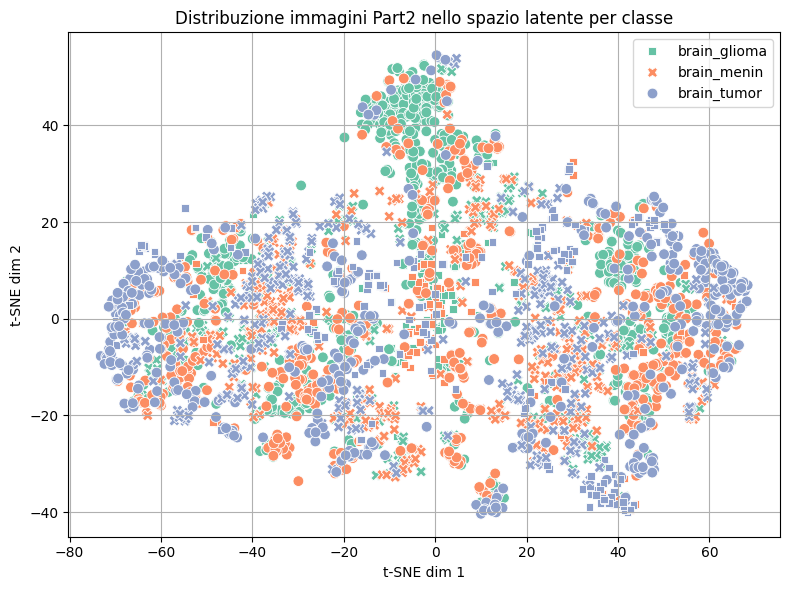

In [ ]:
# Ricostruisci tutti i vettori latenti da Part2 dopo trasformazione per ciascuna classe
X_latent = []
for i, x in enumerate(feat_matrix_part2):
    label = predicted_labels[i]
    model = class_models[label]
    x_scaled = model['scaler'].transform(x.reshape(1, -1))
    x_latent = model['svd'].transform(x_scaled)
    X_latent.append(x_latent[0])

X_latent = np.array(X_latent)

# t-SNE (o PCA se preferisci)
X_2d = TSNE(n_components=2, perplexity=30,
            random_state=0).fit_transform(X_latent)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=lbls_part2,
                style=predicted_labels, palette="Set2", s=60)
plt.title("Distribuzione immagini Part2 nello spazio latente per classe")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

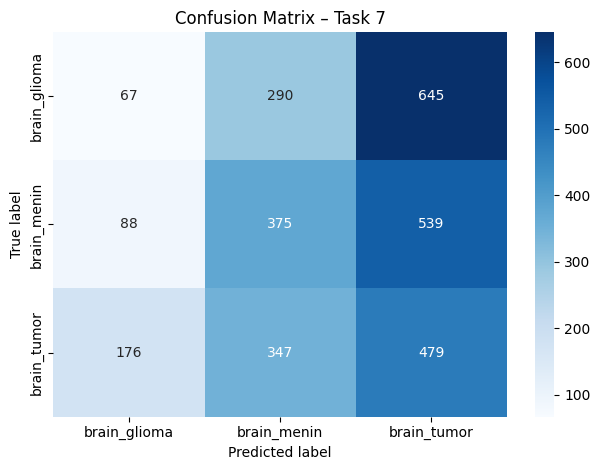

In [ ]:
cm = confusion_matrix(lbls_part2, predicted_labels,
                      labels=np.unique(lbls_part2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(lbls_part2),
            yticklabels=np.unique(lbls_part2))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Task 7")
plt.tight_layout()
plt.show()

# Task 8

Implementa un programma che, per ciascuna etichetta univoca **l**, calcoli i **c cluster più significativi** associati alle immagini della **Parte 1**, utilizzando l'algoritmo **DBSCAN**.

I cluster risultanti devono essere visualizzati in due modalità:
- Come **nuvole di punti** colorate in modo diverso, proiettate in uno spazio a **2 dimensioni** tramite **MDS (Multidimensional Scaling)**.
- Come **gruppi di miniature di immagini**, dove ogni gruppo rappresenta un cluster distinto.

In [ ]:
#Applichiamo tecniche di dimensionality reduction
def reduce_features(features, method, n_components, random_state=42):
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    else:
        raise ValueError(f"Metodo di riduzione '{method}' non supportato.")

    return reducer.fit_transform(features)

#Applichiamo una tecnica di riduzione mediante reduce_feature alle features di partenza ottenendo la lista di Feature Latenti
#Applichiamo su insieme di feature latenti StandardScaler per cercare di ottenere migliori cluster tramite DBSCAN

def apply_dbscan_with_pca(features, eps, min_samples, n_components, method):
    print(f"Applicazione di {method} -> Riduzione a {n_components} componenti")
    reduced_features = reduce_features(features, method, n_components=n_components)
    
    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels

#Calcola i 'c' cluster di maggior cardinalità
def top_c_clusters(cluster_labels, c):
    label_counts = Counter(cluster_labels)
    label_counts.pop(-1, None) # rimozione cluster catalogato come rumore (-1)
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i 'c' cluster più frequenti
    most_common = label_counts.most_common(c)
    top = [int(lbl) for lbl, _ in most_common]
    
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


#Applichiamo al risultato di DBSCAN l'algoritmo di MDS
def plot_mds_clusters(features, cluster_labels, top_clusters, metric):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    #Generazione di una nuova matrice basata sul parametro metric (es. 'cosine')
    D = pairwise_distances(features_scaled, metric=metric)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    Y = mds.fit_transform(D)

    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)
    
    plt.title(f"MDS 2D - Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()

#Genera blocco di immagini trovate per cluster
def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)
            
            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()

In [12]:
#main
def db_scan_detection(eps, min_samples, n_components, c, method):

    # Costruisce l’elenco dei full path per tutte le immagini
    base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
    images_full = [os.path.join(base_folder, lbl, fname) for fname, lbl in zip(flname_part1, lbls_part1)]

    # Scorre ogni label di Parte1 ed applico DBSCAN+PCA
    unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

    for lbl in unique_labels:
        print(f"\n============================")
        print(f"[INFO] Elaboro label: {lbl}")
        print(f"==============================")

        #Estrae le righe di feat_matrix_part1 / flname_part1 corrispondenti
        mask_lbl = (lbls_part1 == lbl)
        features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
        images_label = np.array(images_full)[mask_lbl]

        #Chiama la tua funzione PCA + DBSCAN
        cluster_labels = apply_dbscan_with_pca(
            features_label,
            eps=eps,
            min_samples=min_samples,
            n_components=n_components,
            method = method
        )
        print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

        # Trova i c cluster più grandi
        top_clusters = top_c_clusters(cluster_labels, c)
        print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

        # MDS‐2D + scatter plot del clustering
        print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")

        plot_mds_clusters(
            features_label,
            cluster_labels,
            top_clusters,
            metric='cosine'
        )

        # Creo le miniature di ogni cluster “significativo”
        print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
        show_cluster_thumbnails(
            images_label,      # array di stringhe di percorsi
            cluster_labels,    # array di int di lunghezza n_i
            top_clusters,      # la lista dei c indici di cluster
            thumb_size=(64, 64)
        )

    print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")

In [ ]:
eps = 5.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label
method = 'umap'      # umap or pca
db_scan_detection(eps, min_samples, n_components, c, method)

# Task 9: Classificazione m-NN e Decision Tree

Implementa un programma che, date le immagini della **Parte 1**:

- Crei un classificatore **m-NN** (con **m** specificato dall'utente).
- Crei un classificatore basato su **albero decisionale**.

Per questo task puoi utilizzare **lo spazio delle feature a tua scelta**.

Il programma deve poi:
- Applicare il classificatore selezionato dall'utente per prevedere le etichette più probabili delle immagini della **Parte 2**.
- Calcolare e visualizzare:
  - **Precisione (Precision)** per etichetta,
  - **Richiamo (Recall)** per etichetta,
  - **Punteggio F1 (F1-score)** per etichetta,
  - **Accuratezza complessiva (Accuracy)** del classificatore.

In [20]:
# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))

Risultati m-NN:
              precision    recall  f1-score   support

brain_glioma       0.57      0.88      0.69      1002
 brain_menin       0.77      0.45      0.57      1002
 brain_tumor       0.72      0.62      0.66      1002

    accuracy                           0.65      3006
   macro avg       0.68      0.65      0.64      3006
weighted avg       0.68      0.65      0.64      3006

Accuratezza complessiva m-NN: 0.6493679308050565
Risultati Decision Tree:
              precision    recall  f1-score   support

brain_glioma       0.61      0.58      0.60      1002
 brain_menin       0.52      0.55      0.53      1002
 brain_tumor       0.59      0.58      0.59      1002

    accuracy                           0.57      3006
   macro avg       0.57      0.57      0.57      3006
weighted avg       0.57      0.57      0.57      3006

Accuratezza complessiva Decision Tree: 0.5698602794411177


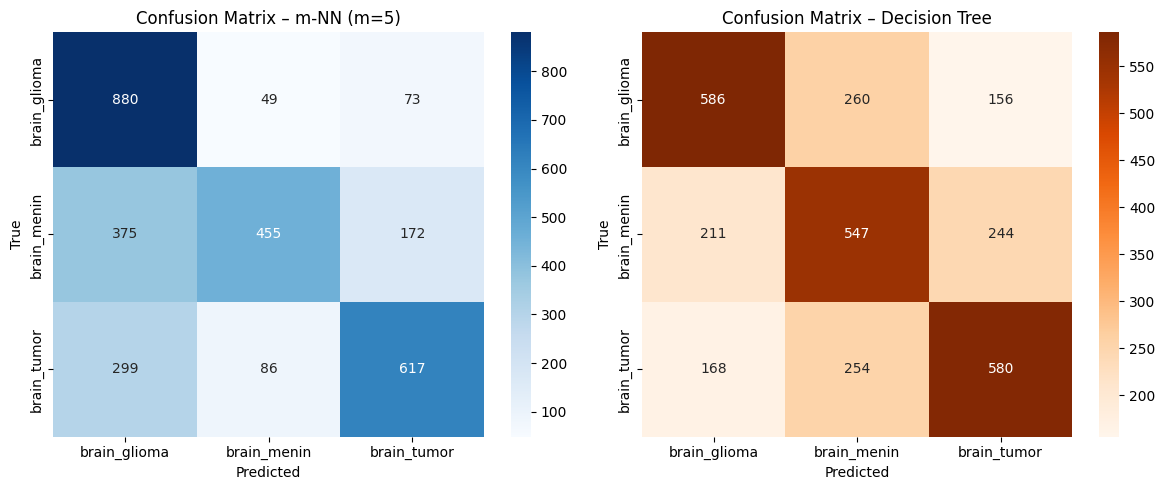

In [24]:
labels = np.unique(lbls_part2)
cm_knn = confusion_matrix(lbls_part2, pred_knn, labels=labels)
cm_dt = confusion_matrix(lbls_part2, pred_dt, labels=labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', ax=axs[0], cmap='Blues', xticklabels=labels, yticklabels=labels)
axs[0].set_title(f"Confusion Matrix – m-NN (m={m})")

sns.heatmap(cm_dt, annot=True, fmt='d', ax=axs[1], cmap='Oranges', xticklabels=labels, yticklabels=labels)
axs[1].set_title("Confusion Matrix – Decision Tree")

for ax in axs:
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

# Task 10: Locality Sensitive Hashing e Ricerca di Immagini Simili

## 10a: Creazione dell'indice LSH

Implementa uno strumento di **Locality Sensitive Hashing (LSH)** (per la distanza euclidea), che prende come input:
- **L**: Numero di livelli,
- **h**: Numero di hash per livello,
- Un insieme di vettori (feature delle immagini).

Il programma deve creare **una struttura di indice in memoria** contenente l'insieme di vettori dato.

> Riferimento:  
> "Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions",  
> Alexandr Andoni e Piotr Indyk, *Communications of the ACM*, vol. 51, no. 1, 2008, pp. 117–122.

---

## 11b: Ricerca di immagini simili con LSH

Implementa un algoritmo di ricerca di immagini simili utilizzando la struttura LSH creata in 11a, memorizzando le immagini della **Parte 1** e un modello visivo di tua scelta (**il modello visivo combinato deve avere almeno 256 dimensioni**).

Per una data immagine di query e un numero intero **t**, il programma deve:

- Visualizzare le **t immagini più simili**.
- Mostrare:
  - Il **numero di immagini uniche** considerate,
  - Il **numero totale di immagini analizzate** durante il processo.

In [51]:
class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea con quantizzazione (p-stable).
    num_layers = L, num_hashes = h, dim = D, r = bucket width.
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        self.hash_tables = [defaultdict(list) for _ in range(self.L)]
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        bits = []
        for j in range(self.h):
            a_j = self.a_vectors[layer_idx][j]
            b_j = self.b_offsets[layer_idx][j]
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            bits.append(h_val)
        return tuple(bits)

    def index(self, vectors: np.ndarray):
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Dimensione vettore ({D}) ≠ D di LSH ({self.d})."
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        assert q_vec.shape[0] == self.d, "Dimensione query ≠ D."
        candidati = set()
        total_checked = 0
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked

In [40]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 7                      # numero di funzioni concatenati in ciascuna tavola
r = 1                       # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


[INFO] LSH quantizzato costruito: D=900, L=10, h=7, r=1


In [41]:
#funzione per cercare top_k con LSH quantizzato
def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Cerca le k immagini di Part1 più simili a img_path (di Part2) usando LSH_EuclideanQuantized.
    Stampa:
      - i primi k risultati (file name, label, distanza)
      - il numero di immagini uniche considerate
      - il numero totale di controlli (somma delle lunghezze dei bucket)
    E poi visualizza (query + k risultati) con matplotlib.
    """
    # 1) Estrazione feature raw (900-dim) con la funzione esistente
    raw_q = np.array(extract_hog_features(img_path), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec e L2 norm usati su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata a LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampa output testuale
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + primi k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



[LSH-Quant] Top 7 simili a: Part2/brain_glioma/brain_glioma_1409.jpg
  1. brain_tumor_0681.jpg | Classe: brain_tumor | Distanza Euclidea: 1.21
  2. brain_tumor_0371.jpg | Classe: brain_tumor | Distanza Euclidea: 1.31
  3. brain_tumor_0891.jpg | Classe: brain_tumor | Distanza Euclidea: 1.31
  4. brain_glioma_0635.jpg | Classe: brain_glioma | Distanza Euclidea: 1.33
[LSH-Quant] Immagini uniche considerate: 4
[LSH-Quant] Immagini totali controllate: 4


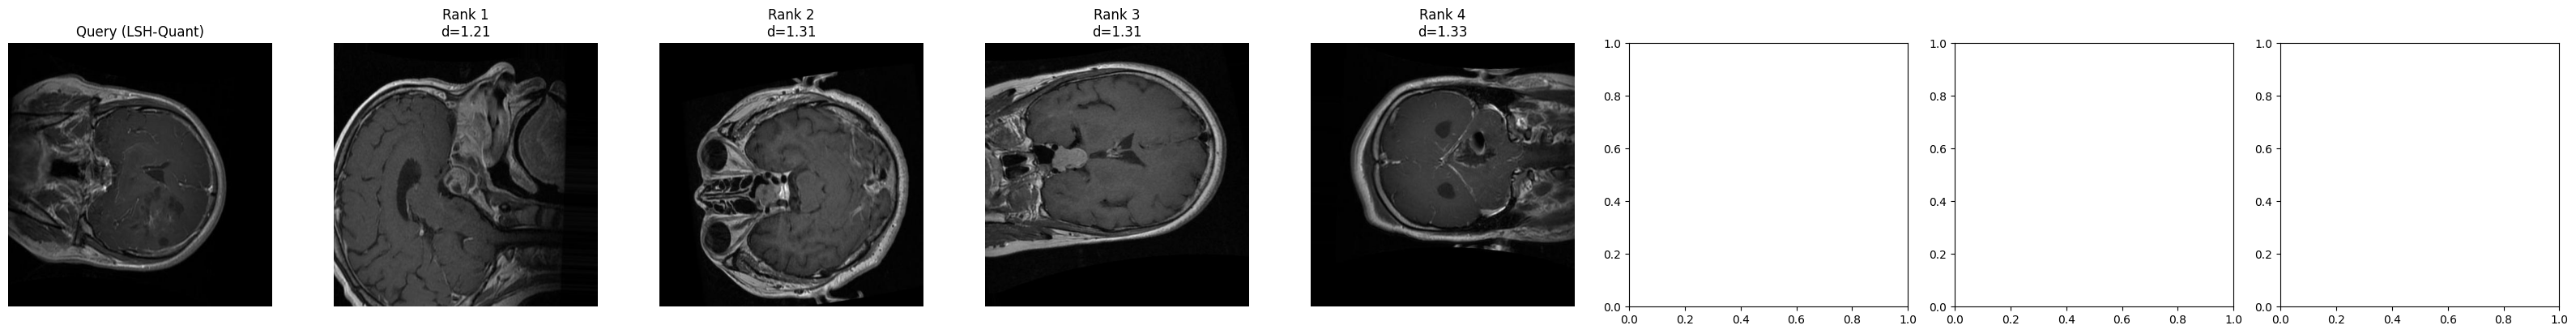

In [53]:
# Esempio di utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_glioma/brain_glioma_1409.jpg"

k = 7                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)

In [43]:
def compare_lsh_vs_brute(query_path, t=5):
    # Feature query
    raw_q = np.array(extract_hog_features(query_path), dtype=np.float32)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # --- LSH ---
    t0 = time.time()
    lsh_results, uniq_lsh, total_lsh = lsh_quant.query(q_normed, top_t=t)
    t_lsh = time.time() - t0

    # --- Brute force ---
    t1 = time.time()
    dists = np.linalg.norm(feat_normed - q_normed, axis=1)
    brute_top = np.argsort(dists)[:t]
    t_brute = time.time() - t1

    mean_lsh = np.mean([d for _, d in lsh_results])
    mean_brute = np.mean(dists[brute_top])

    print(f"\nTempo LSH: {t_lsh:.4f}s | Tempo brute: {t_brute:.4f}s")
    print(f"Distanza media LSH: {mean_lsh:.2f} | brute: {mean_brute:.2f}")
    print(
        f"Immagini controllate (LSH): {total_lsh} | brute: {feat_normed.shape[0]}")

    # Barplot confronto
    metrics = ['Immagini controllate']
    values_lsh = [t_lsh, mean_lsh, total_lsh]
    values_bf = [t_brute, mean_brute, feat_normed.shape[0]]

    plt.figure(figsize=(7, 4))
    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, values_lsh, width, label='LSH')
    plt.bar(x + width/2, values_bf, width, label='Brute Force')
    plt.xticks(x, metrics)
    plt.title("Confronto LSH vs Ricerca esaustiva")
    plt.legend()
    plt.tight_layout(); plt.show()


Tempo LSH: 0.0006s | Tempo brute: 0.0276s
Distanza media LSH: 0.99 | brute: 0.74
Immagini controllate (LSH): 13 | brute: 3006


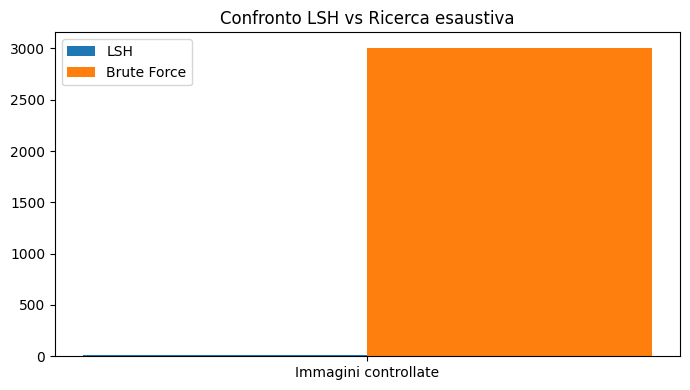

In [54]:
compare_lsh_vs_brute("Part1/brain_menin/brain_menin_0005.jpg")